<a href="https://colab.research.google.com/github/jessie040718/CVFX-homework-4/blob/master/HW4_team7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CVFX homework 4

本次作業需要我們在校園中拍一些照片，並利用feature extraction技術（例如orb、SIFT、SURF）對這些照片做matching， 用這些matching對照片做alignment，以製造出zoom in的效果。同時也要比較不同feature extration做出來的結果。

在這些照片中，因為我們的色調還滿一致的，所以問題比較少；主要是在align的時候，因為樹與路的邊會變形，導致出來的結果會不一致、不自然，所以我們先用edge enhence增加邊的辨識度，再用blur來稍微消除這些痕跡。

## Taking a Sequence of Moving-forward Photo in NTHU campus

我們照的照片是楓林小徑，要走上人社院的坡。

照片在這： https://drive.google.com/drive/u/0/folders/1cUR4V76VG6DpgVZ-LzEVc3LfOJngAWjO



In [1]:
# Connect to Google Drive from youtself
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# Ensure the image is exists
!ls "/content/drive/My Drive/cvfx/Hw4照片"

orb_1.png		 P_20190416_125403.jpg	P_20190416_125548.jpg
orb_2.png		 P_20190416_125409.jpg	P_20190416_125548_s.jpg
P_20190416_125325.jpg	 P_20190416_125414.jpg	sift_1.png
P_20190416_125325_s.jpg  P_20190416_125419.jpg	sift_2.png
P_20190416_125333.jpg	 P_20190416_125424.jpg	surf_1.png
P_20190416_125344.jpg	 P_20190416_125519.jpg	surf_2.png
P_20190416_125351.jpg	 P_20190416_125530.jpg
P_20190416_125357.jpg	 P_20190416_125542.jpg


## Feature Extraction and Matching Results between 2 Images

我們選用以下兩張照片：

In [0]:
# Import package for feature matching 
import numpy as np
import cv2
from matplotlib import pyplot as plt

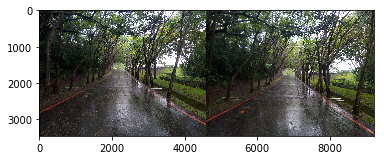

(<matplotlib.image.AxesImage at 0x7fbdb53455c0>, None)

In [0]:
img1 = cv2.imread('/content/drive/My Drive/cvfx/Hw4照片/P_20190416_125344.jpg', cv2.IMREAD_COLOR)[...,::-1]
img2 = cv2.imread('/content/drive/My Drive/cvfx/Hw4照片/P_20190416_125351.jpg', cv2.IMREAD_COLOR)[...,::-1]
# img1 = img

pic = np.hstack((img1, img2))
plt.imshow(pic),plt.show()

### Install packages
因為SIFT跟SURF所在的cv2.xfeatures2d是opencv額外的module，所以需要另外下載opencv-contrib-python，而且要跟opencv的版本一樣。

In [5]:
!pip install opencv_python==3.4.2.16 
!pip install opencv-contrib-python==3.4.2.16

    100% |████████████████████████████████| 25.0MB 1.5MB/s 
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: opencv-python 3.4.5.20
    Uninstalling opencv-python-3.4.5.20:
      Successfully uninstalled opencv-python-3.4.5.20


    100% |████████████████████████████████| 30.6MB 1.0MB/s 
  Found existing installation: opencv-contrib-python 3.4.3.18
    Uninstalling opencv-contrib-python-3.4.3.18:
      Successfully uninstalled opencv-contrib-python-3.4.3.18


### Input
把image讀進來，image大約都3000x4000在colab的顯示時會太大，所以先resize成十分之一倍。 imread的第二個參數助教給0，這樣就會是灰階，我們改成cv2.IMREAD_COLOR以讀彩色照片。之後channel的調整是因為cv2讀取的顏色是BGR，所以要在最後一個channel整個相反成RGB，顯示出來才是正常的。



In [0]:
# Read image
img1 = cv2.resize(cv2.imread('/content/drive/My Drive/cvfx/Hw4照片/P_20190416_125344.jpg', cv2.IMREAD_COLOR), None, fx=0.1, fy=0.1)
img2 = cv2.resize(cv2.imread('/content/drive/My Drive/cvfx/Hw4照片/P_20190416_125351.jpg', cv2.IMREAD_COLOR), None, fx=0.1, fy=0.1)
img1 = img1[...,::-1]
img2 = img2[...,::-1]

### Feature Extraction + Image Alignment
Feature extraction的流程如下：
1. 初使化一種feature detector
2. 用這個detector分別在兩張照片上找key points，detectAndCompute會回傳keypoints跟descriptors作為之後matching使用。
3. BFMatcher是用來計算descriptor距離的，crossCheck設true是為了產生較好的結果。
4. call bf.match()來產生兩張圖之間的matching的距離，並用遞增的方式排列，因為距離越小表示越接近。
5. 之後採用這些matches的中距離最近的前15%，相信這樣足夠正確也足夠多做採樣。
6. 要比較的話，用drawMatches畫出結果。


Image Alignment的流程如下：
1. 找出這15%matches的位置存在np array裡。
2. 求homography。同一平面上、不同視角的兩張圖片之及的關係可以用homography表示，homoprahy是一個3x3的矩陣。  
令($x_1$, $y_1$), ($x_2$, $y_2$)分別是第一張與第二張圖對應的點。Homography的公式表示如下：  
$$
H = 
 \begin{bmatrix}
   h_{00} & h_{01} & h_{02} \\
   h_{10} & h_{11} & h_{12} \\
   h_{20} & h_{21} & h_{22}
  \end{bmatrix}
$$
  
$$\begin{bmatrix}
  x_1 \\
  y_1 \\
  1
  \end{bmatrix}=
  H
  \begin{bmatrix}
  x_2 \\
  y_2 \\
  1
  \end{bmatrix}=\begin{bmatrix}
   h_{00} & h_{01} & h_{02} \\
   h_{10} & h_{11} & h_{12} \\
   h_{20} & h_{21} & h_{22}
  \end{bmatrix}
  \begin{bmatrix}
  x_2 \\
  y_2 \\
  1
  \end{bmatrix}
$$

3. 有了homography之後，我們使用warpPerspective將遠景img2 match到近景img1上，可以看到這時候的圖會有一些黑色的部分，就是match後轉動視角的結果。

#### ORB

In [0]:
def ORB_extract(img1, img2):
  # Initiate ORB detector
  orb = cv2.ORB_create()

  # find the keypoints and descriptors with ORB
  kp1, des1 = orb.detectAndCompute(img1,None)
  kp2, des2 = orb.detectAndCompute(img2,None)
  
  # create BFMatcher object
  bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

  # Match descriptors.
  matches = bf.match(des1,des2)

  # Sort them in the order of their distance.
  matches = sorted(matches, key = lambda x:x.distance)
  img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches,None, flags=2)
  
  # Take the best 15% matches.
  GOOD_MATCH_PERCENT = 0.15
  goodMatch = int(len(matches) * GOOD_MATCH_PERCENT)
  matches = matches[:goodMatch]
  
  # Extract location of good matches
  points1 = np.zeros((goodMatch, 2), dtype=np.float32)
  points2 = np.zeros((goodMatch, 2), dtype=np.float32)

  for i, match in enumerate(matches):
    points1[i, :] = kp1[match.queryIdx].pt
    points2[i, :] = kp2[match.trainIdx].pt

  # Find homography
  h, _ = cv2.findHomography(points2, points1, cv2.RANSAC)     # make img2 to match img1

  # Use homography
  height, width, channels = img1.shape
  im1Reg = cv2.warpPerspective(img2,  h, (width, height))
  
  return im1Reg
  

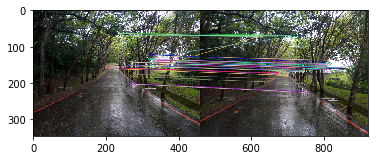

(<matplotlib.image.AxesImage at 0x7fe817ca4fd0>, None)

In [0]:
img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches,None, flags=2)
plt.imshow(img3),plt.show()

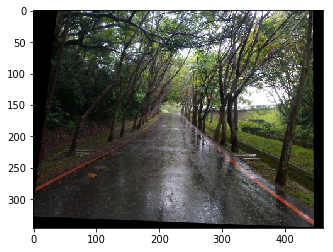

(<matplotlib.image.AxesImage at 0x7fbdb5632080>, None)

In [0]:
im1Reg = ORB_extract(img1, img2)
plt.imshow(im1Reg), plt.show()

#### SIFT

In [0]:
def SIFT_extract(img1, img2):
  # Initiate SIFT detector
  sift = cv2.xfeatures2d.SIFT_create()

  # find the keypoints and descriptors with SIFT
  kp1, des1 = sift.detectAndCompute(img1,None)
  kp2, des2 = sift.detectAndCompute(img2,None)

  # create BFMatcher object
  bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

  # Match descriptors.
  matches = bf.match(des1,des2)

  # Sort them in the order of their distance.
  matches = sorted(matches, key = lambda x:x.distance)

  # Take the best 15% matches.
  GOOD_MATCH_PERCENT = 0.15
  goodMatch = int(len(matches) * GOOD_MATCH_PERCENT)
  matches = matches[:goodMatch]

  
  # Extract location of good matches
  points1 = np.zeros((goodMatch, 2), dtype=np.float32)
  points2 = np.zeros((goodMatch, 2), dtype=np.float32)

  for i, match in enumerate(matches):
    points1[i, :] = kp1[match.queryIdx].pt
    points2[i, :] = kp2[match.trainIdx].pt

  # Find homography
  h, _ = cv2.findHomography(points2, points1, cv2.RANSAC)     # make img2 to match img1

  # Use homography
  height, width, channels = img1.shape
  im1Reg = cv2.warpPerspective(img2,  h, (width, height))

  return im1Reg

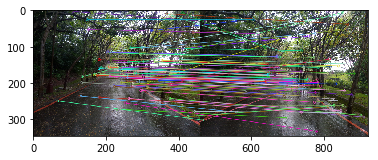

(<matplotlib.image.AxesImage at 0x7fe813b34fd0>, None)

In [0]:
img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches,None, flags=2)
plt.imshow(img3),plt.show()

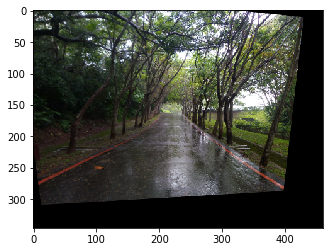

(<matplotlib.image.AxesImage at 0x7fbdb5417588>, None)

In [0]:
im1Reg = SIFT_extract(img1, img2)
plt.imshow(im1Reg), plt.show()

#### SURF

In [0]:
def SURF_extract(img1, img2):
  # Initiate SURF detector
  surf = cv2.xfeatures2d.SURF_create()

  # find the keypoints and descriptors with SURF
  kp1, des1 = surf.detectAndCompute(img1,None)
  kp2, des2 = surf.detectAndCompute(img2,None)

  # create BFMatcher object
  bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

  # Match descriptors.
  matches = bf.match(des1,des2)

  # Sort them in the order of their distance.
  matches = sorted(matches, key = lambda x:x.distance)

  # Take the best 15% matches.
  GOOD_MATCH_PERCENT = 0.15
  goodMatch = int(len(matches) * GOOD_MATCH_PERCENT)
  matches = matches[:goodMatch]
  
  # Extract location of good matches
  points1 = np.zeros((goodMatch, 2), dtype=np.float32)
  points2 = np.zeros((goodMatch, 2), dtype=np.float32)

  for i, match in enumerate(matches):
    points1[i, :] = kp1[match.queryIdx].pt
    points2[i, :] = kp2[match.trainIdx].pt

  # Find homography
  h, _ = cv2.findHomography(points2, points1, cv2.RANSAC)     # make img2 to match img1

  # Use homography
  height, width, channels = img1.shape
  im1Reg = cv2.warpPerspective(img2,  h, (width, height))
  
  return im1Reg

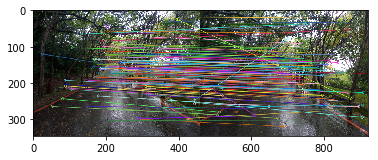

(<matplotlib.image.AxesImage at 0x7fe813a74c88>, None)

In [0]:
img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches,None, flags=2)
plt.imshow(img3),plt.show()

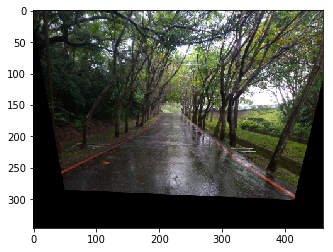

(<matplotlib.image.AxesImage at 0x7fbdb53e32e8>, None)

In [0]:
im1Reg = SURF_extract(img1, img2)
plt.imshow(im1Reg), plt.show()

### 將align之後的圖片疊起來
將圖片對齊好之後，我們就要把它們疊在一起使畫面延伸。Match_Merge()是為了讓傳入的兩張圖片正確的疊在一起。其中第一個參數(img1)是原本圖片，第二個參數(changed_img)是經過轉換後與img1對齊的圖片。

步驟:
1. 找出changed_img實際有內容的部分並做成mask。

   a. 將changed_img轉成灰階並用threshold將所有值大於零的像素都變成255(白色)，白色部分大致上都是有內容部分。
   
   b. 為了避免內容部分也有像素值為零的地方，因此接著要用findContours找出邊界，並把邊界內都塗成白色，才確保mask的正確性。
   
   c. 由於現在mask是反的，因此還要做Inverse(使用bitwise_not)。
   
2. 將img1套上mask使它在所有changed_img對應的地方都變成零(黑色)。(使用bitwise_and)  
3. 將img1和changed_img做OR運算，即可正確合併兩張圖。

In [0]:
def Match_Merge(img1, changed_img):          #img1 is img1 .  changed_img is im1Reg,which is the result of alignment
    # make mask
    gray = cv2.cvtColor(changed_img,cv2.COLOR_BGR2GRAY)
    ret, binary = cv2.threshold(gray,0,255,cv2.THRESH_BINARY)                                   # >0 change to 255

    #find the exactly borders in mask
    _, contours, hierarchy = cv2.findContours(binary,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)   #find borders
    cv2.drawContours(gray, contours, -1, (255,255,255))                                         #draw the borders

    cv2.drawContours(gray, contours, -1, (255,255,255),  thickness=-1)                          #fill in the borders with white

    gray_3 = cv2.cvtColor(gray,cv2.COLOR_GRAY2BGR)  #change gray to 3 channel:gray_3
    img_inv = cv2.bitwise_not(gray_3)               #inverse the gray(mask)
    img_out = cv2.bitwise_and(img1,img_inv)         #merge img1 with mask
    img_f = cv2.bitwise_or(img_out, changed_img)    #merge img1(mask) and img2
    
    return img_f

那麼我們就把裡面10張照片讀進來存在一個list裡，用一個迴圈來把所有照片疊在一起。三個feature extraction都要做一遍，我們把過程的照片也印出來，可以看到圖片的變化。

In [0]:
imgs = []
imgs.append(cv2.resize(cv2.imread('/content/drive/My Drive/cvfx/Hw4照片/P_20190416_125344.jpg', cv2.IMREAD_COLOR), None, fx=0.25, fy=0.25)[...,::-1])
imgs.append(cv2.resize(cv2.imread('/content/drive/My Drive/cvfx/Hw4照片/P_20190416_125351.jpg', cv2.IMREAD_COLOR), None, fx=0.25, fy=0.25)[...,::-1])
imgs.append(cv2.resize(cv2.imread('/content/drive/My Drive/cvfx/Hw4照片/P_20190416_125357.jpg', cv2.IMREAD_COLOR), None, fx=0.25, fy=0.25)[...,::-1])
imgs.append(cv2.resize(cv2.imread('/content/drive/My Drive/cvfx/Hw4照片/P_20190416_125403.jpg', cv2.IMREAD_COLOR), None, fx=0.25, fy=0.25)[...,::-1])
imgs.append(cv2.resize(cv2.imread('/content/drive/My Drive/cvfx/Hw4照片/P_20190416_125409.jpg', cv2.IMREAD_COLOR), None, fx=0.25, fy=0.25)[...,::-1])
imgs.append(cv2.resize(cv2.imread('/content/drive/My Drive/cvfx/Hw4照片/P_20190416_125414.jpg', cv2.IMREAD_COLOR), None, fx=0.25, fy=0.25)[...,::-1])
imgs.append(cv2.resize(cv2.imread('/content/drive/My Drive/cvfx/Hw4照片/P_20190416_125424.jpg', cv2.IMREAD_COLOR), None, fx=0.25, fy=0.25)[...,::-1])
imgs.append(cv2.resize(cv2.imread('/content/drive/My Drive/cvfx/Hw4照片/P_20190416_125519.jpg', cv2.IMREAD_COLOR), None, fx=0.25, fy=0.25)[...,::-1])
imgs.append(cv2.resize(cv2.imread('/content/drive/My Drive/cvfx/Hw4照片/P_20190416_125530.jpg', cv2.IMREAD_COLOR), None, fx=0.25, fy=0.25)[...,::-1])
imgs.append(cv2.resize(cv2.imread('/content/drive/My Drive/cvfx/Hw4照片/P_20190416_125542.jpg', cv2.IMREAD_COLOR), None, fx=0.25, fy=0.25)[...,::-1])

In [0]:

imgs = []
imgs.append(cv2.resize(cv2.imread('/content/drive/My Drive/cvfx/Hw4照片/P_20190416_125344.jpg', cv2.IMREAD_COLOR), None, fx=0.1, fy=0.1)[...,::-1])
imgs.append(cv2.resize(cv2.imread('/content/drive/My Drive/cvfx/Hw4照片/P_20190416_125351.jpg', cv2.IMREAD_COLOR), None, fx=0.1, fy=0.1)[...,::-1])
imgs.append(cv2.resize(cv2.imread('/content/drive/My Drive/cvfx/Hw4照片/P_20190416_125357.jpg', cv2.IMREAD_COLOR), None, fx=0.1, fy=0.1)[...,::-1])
imgs.append(cv2.resize(cv2.imread('/content/drive/My Drive/cvfx/Hw4照片/P_20190416_125403.jpg', cv2.IMREAD_COLOR), None, fx=0.1, fy=0.1)[...,::-1])
imgs.append(cv2.resize(cv2.imread('/content/drive/My Drive/cvfx/Hw4照片/P_20190416_125409.jpg', cv2.IMREAD_COLOR), None, fx=0.1, fy=0.1)[...,::-1])
imgs.append(cv2.resize(cv2.imread('/content/drive/My Drive/cvfx/Hw4照片/P_20190416_125414.jpg', cv2.IMREAD_COLOR), None, fx=0.1, fy=0.1)[...,::-1])
imgs.append(cv2.resize(cv2.imread('/content/drive/My Drive/cvfx/Hw4照片/P_20190416_125424.jpg', cv2.IMREAD_COLOR), None, fx=0.1, fy=0.1)[...,::-1])
imgs.append(cv2.resize(cv2.imread('/content/drive/My Drive/cvfx/Hw4照片/P_20190416_125519.jpg', cv2.IMREAD_COLOR), None, fx=0.1, fy=0.1)[...,::-1])
imgs.append(cv2.resize(cv2.imread('/content/drive/My Drive/cvfx/Hw4照片/P_20190416_125530.jpg', cv2.IMREAD_COLOR), None, fx=0.1, fy=0.1)[...,::-1])
imgs.append(cv2.resize(cv2.imread('/content/drive/My Drive/cvfx/Hw4照片/P_20190416_125542.jpg', cv2.IMREAD_COLOR), None, fx=0.1, fy=0.1)[...,::-1])

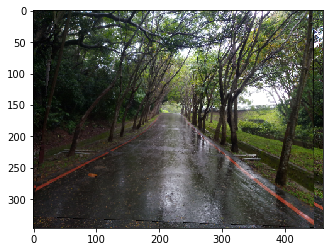

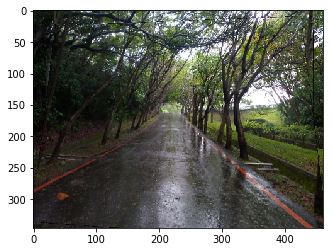

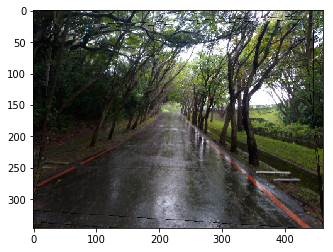

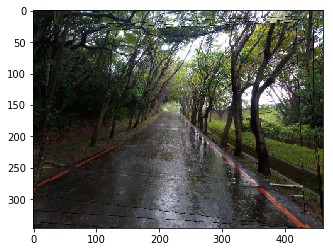

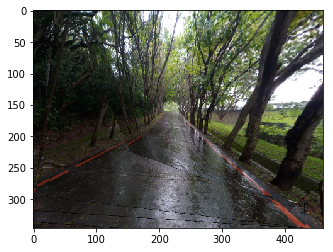

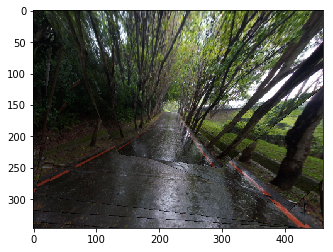

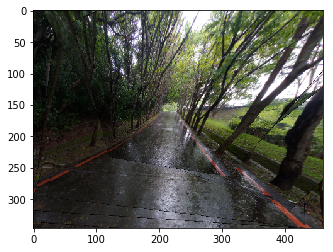

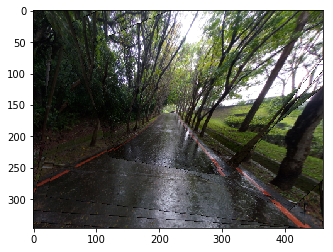

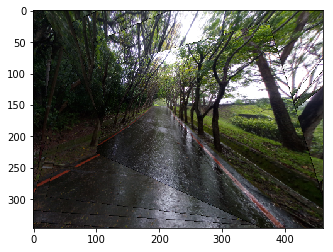

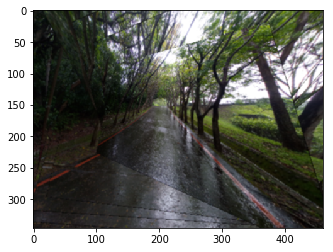

In [38]:
from PIL import ImageFilter
from PIL import Image
# ORB
img_orb = imgs[0]
for i, img in enumerate(imgs):
  if i != len(imgs)-1:
    img[i+1]=Image.fromarray(img[i+1]).filter(ImageFilter.EDGE_ENHANCE)
    im1Reg = ORB_extract(img_orb, imgs[i+1])
    img_orb = Match_Merge(img_orb, im1Reg)
    
  else:
    img_orb = cv2.GaussianBlur(img_orb, (3, 3), 0)
  plt.imshow(img_orb), plt.show()
    


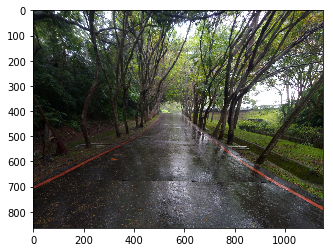

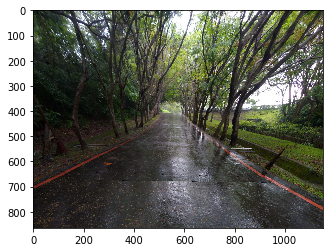

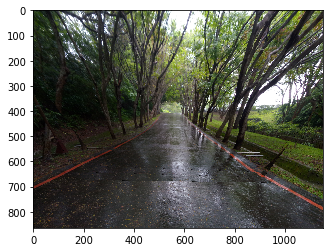

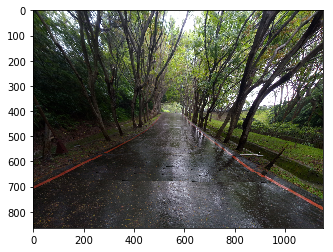

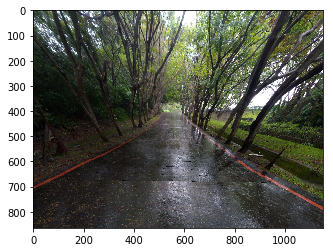

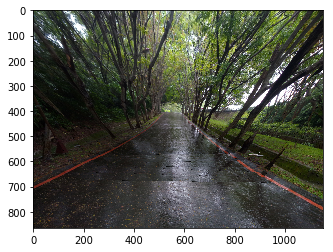

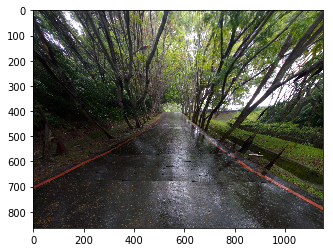

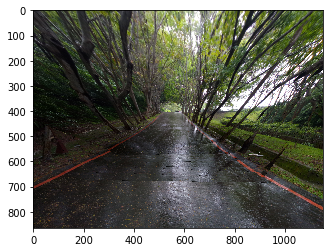

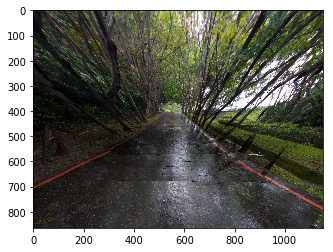

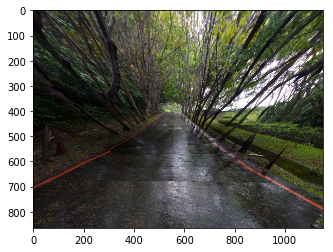

In [16]:
#SIFT
img_sift = imgs[0]
for i, img in enumerate(imgs):
  if i != len(imgs)-1:
    img[i+1]=Image.fromarray(img[i+1]).filter(ImageFilter.EDGE_ENHANCE)
    im1Reg = SIFT_extract(img_sift, imgs[i+1])
    img_sift = Match_Merge(img_sift, im1Reg)
  else:
    img_sift = cv2.GaussianBlur(img_sift, (3, 3), 0)
  plt.imshow(img_sift), plt.show()

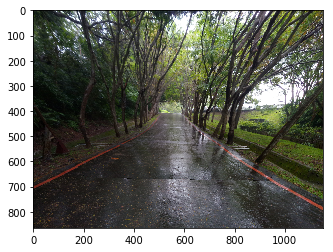

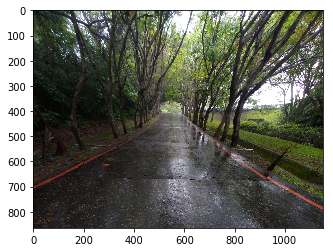

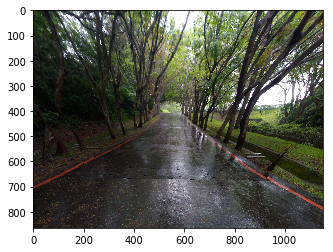

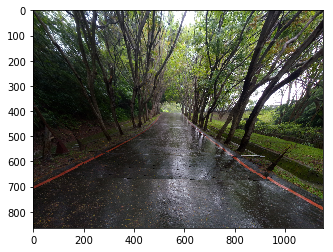

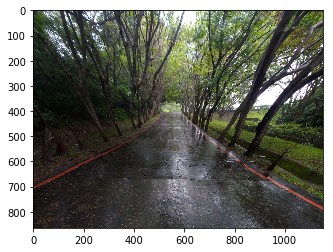

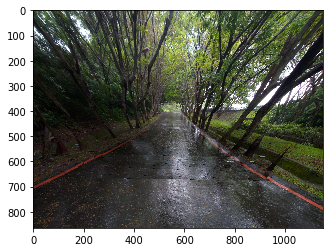

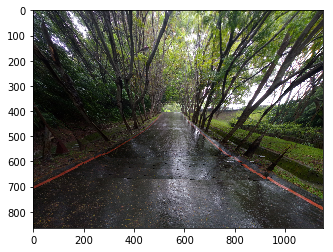

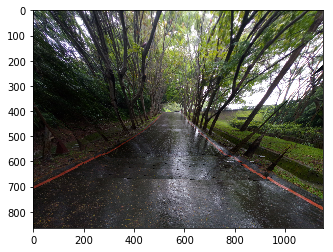

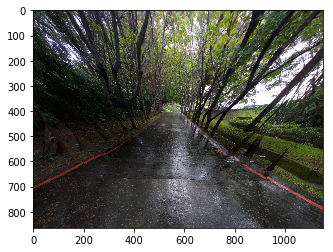

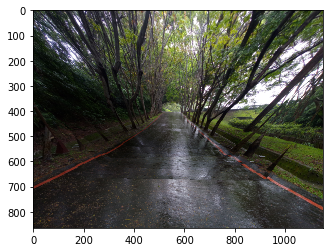

In [17]:
#SURF
img_surf = imgs[0]
for i, img in enumerate(imgs):
  if i != len(imgs)-1:
    img[i+1]=Image.fromarray(img[i+1]).filter(ImageFilter.EDGE_ENHANCE)
    im1Reg = SURF_extract(img_surf, imgs[i+1])
    img_surf = Match_Merge(img_surf, im1Reg)
  else:
    img_surf = cv2.GaussianBlur(img_surf, (3, 3), 0)
  plt.imshow(img_surf), plt.show()

### 結果
由上而下分別是ORB、SIFT、SURF。上部分是沒有做任何處理，下部份是對每張圖做edge enhence跟最後做blur的結果。

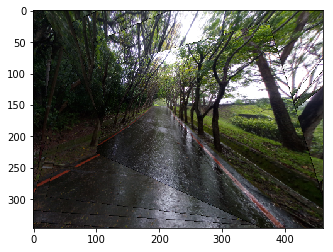

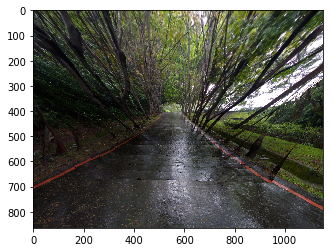

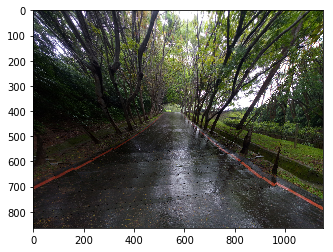

(<matplotlib.image.AxesImage at 0x7f0d756b0dd8>, None)

In [48]:
plt.imshow(img_o), plt.show()
plt.imshow(img_si), plt.show()
plt.imshow(img_su), plt.show()

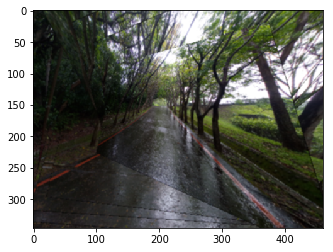

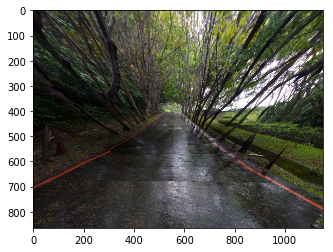

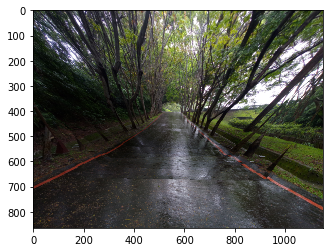

(<matplotlib.image.AxesImage at 0x7f0d79e3ca58>, None)

In [39]:
plt.imshow(img_orb), plt.show()
plt.imshow(img_sift), plt.show()
plt.imshow(img_surf), plt.show()

#### Comparison
|項目|orb|sift|surf|
|:--:|:--:|:--:|:--:|
|沒處理|<img src="https://drive.google.com/uc?id=1-2fXbkWsF2WyoK8926mPrLkug9jSmjvN" width="400"/>|<img src="https://drive.google.com/uc?id=1-3ncAtcurDHl9__NOkEnHvyxBQFJRxHj" width="400"/>|<img src="https://drive.google.com/uc?id=1-5d-5mHxlUSDdLCxfXel1Xlt8tAl8Vcr" width="400"/>|
|有edge enhence & blur|<img src="https://drive.google.com/uc?id=1--2dBB7Cvd3k5nZwwgCnlZjy21S7bYD_" width="400"/>|<img src="https://drive.google.com/uc?id=1-0Lvyi_LK3rqm24HOr2WVc8NJY1OwWvh" width="400"/>|<img src="https://drive.google.com/uc?id=1-2ZLUKKeEgWFCI_1KTlM0kTVMMJa1SqC" width="400"/>|

<!-- <img src="" width="400"/> -->




#### 存取照片
把前面最後跑完的照片存下來。


In [0]:
from google.colab import files
cv2.imwrite('/content/drive/My Drive/cvfx/Hw4照片/orb.png', img_orb[...,::-1])
cv2.imwrite('/content/drive/My Drive/cvfx/Hw4照片/sift.png', img_sift[...,::-1])
cv2.imwrite('/content/drive/My Drive/cvfx/Hw4照片/surf.png', img_surf[...,::-1])
files.download('orb.png')
files.download('sift.png')
files.download('surf.png')

## Zoom in

### ORB with edge enhence and blur

### SIFT with edge enhence and blur

### SURF with edge enhence and blur


### 使用Photoshop

https://youtu.be/ttrK8bg6ZZc

總共使用七張圖片，以對齊馬路上兩條紅線為主要目標，將每張圖都設為前一張長寬的0.7~0.8倍，而除了修改圖片的亮度與對比外，還將圖片間銜接處用羽化處理使接點較不明顯。